## Analyse FFPE Invasive Ductal Carcinoma Breast Tissue with scanpy then identify SVGs with SpatialDE

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import scanorama
import csv
from sklearn.metrics.pairwise import cosine_distances

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)


%load_ext autoreload
%autoreload 2

In [3]:
#Load in breast cancer data from local instance
ffpe_human_breast_cancer = sc.read_visium('.',count_file='Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5')
ffpe_human_breast_cancer.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
#Calculate some QC metrics for the data
ffpe_human_breast_cancer.var["mt"] = ffpe_human_breast_cancer.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(ffpe_human_breast_cancer, qc_vars=["mt"], inplace=True)

<IPython.core.display.Javascript object>


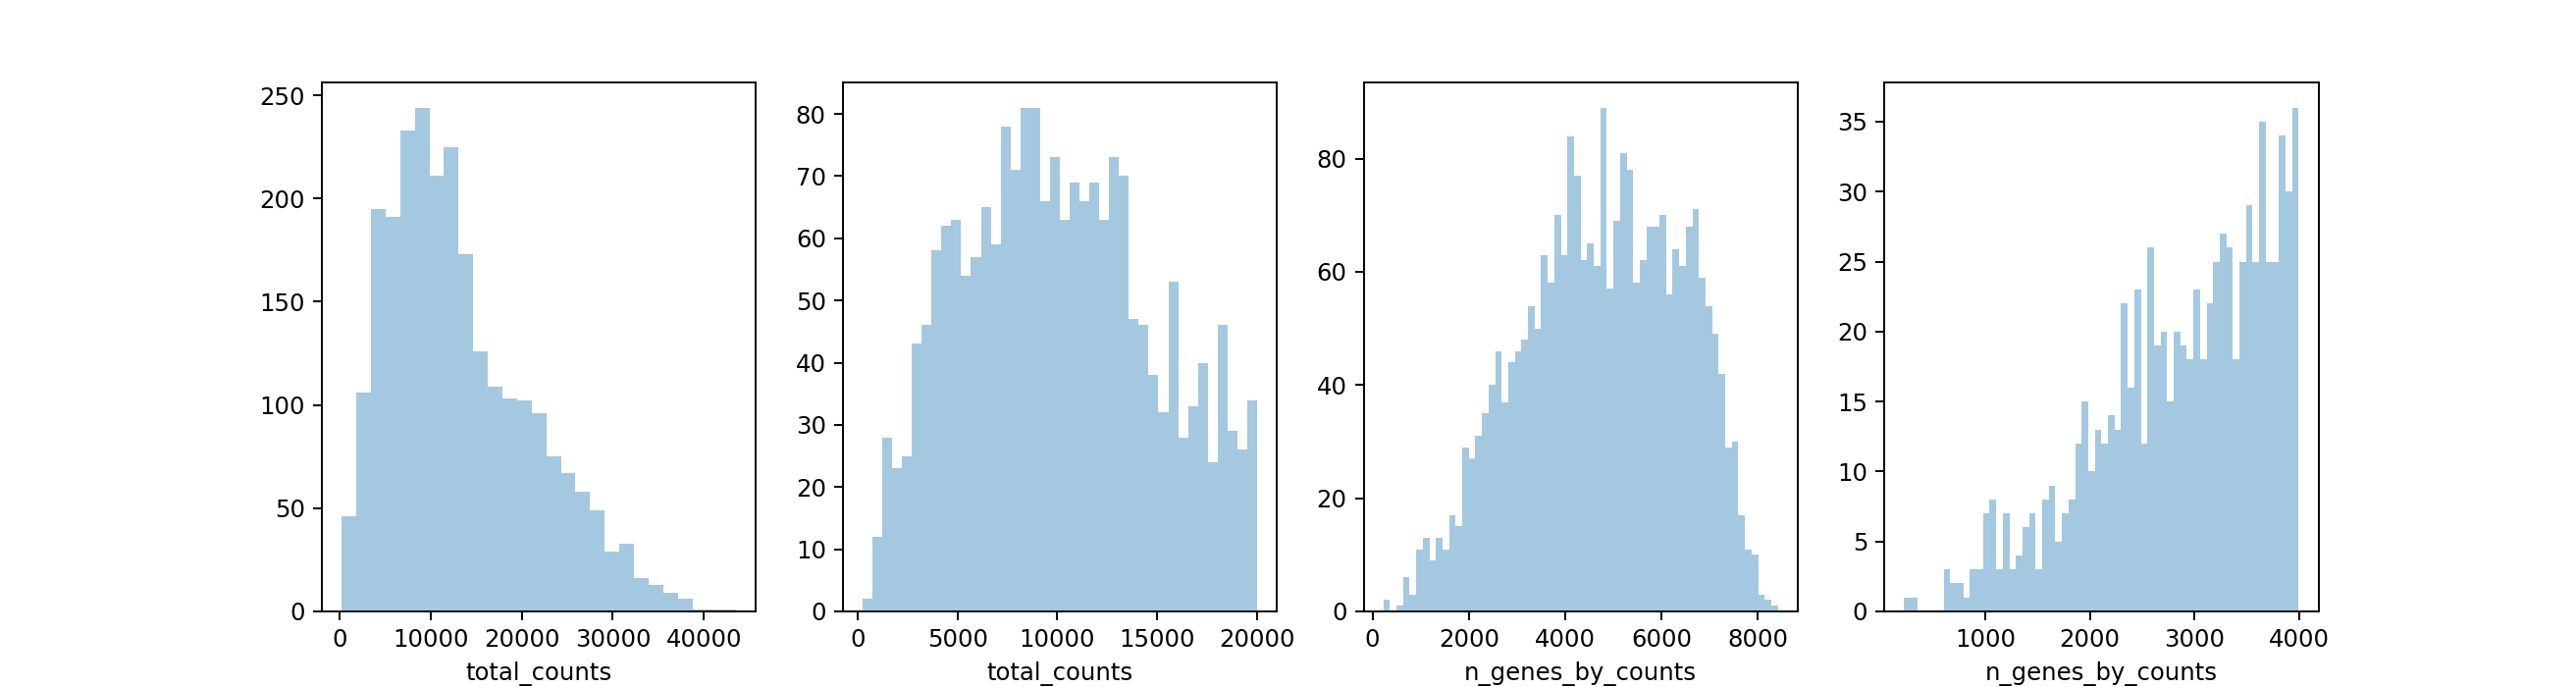

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categori

<IPython.core.display.Javascript object>


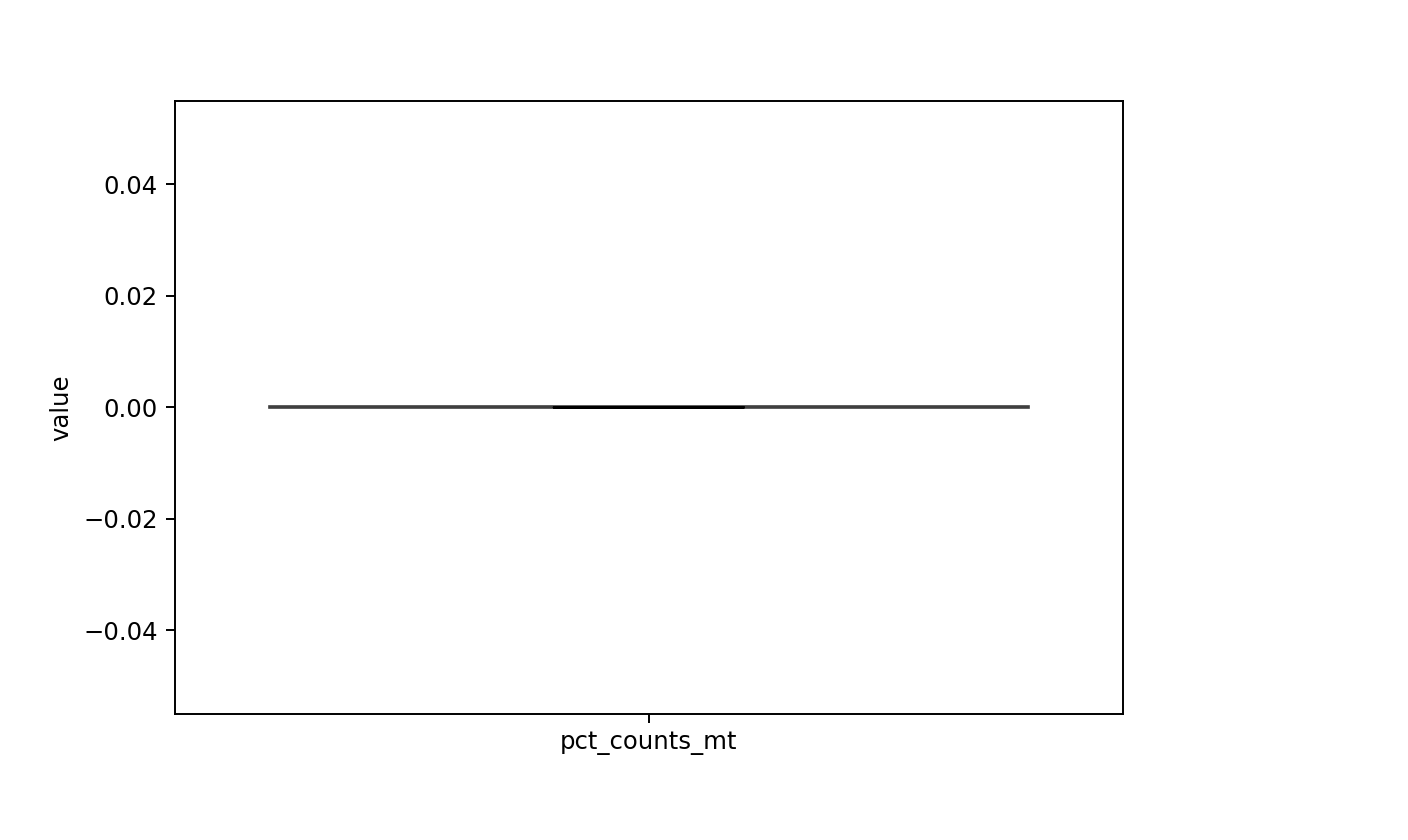

In [5]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ffpe_human_breast_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ffpe_human_breast_cancer.obs["total_counts"][ffpe_human_breast_cancer.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ffpe_human_breast_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ffpe_human_breast_cancer.obs["n_genes_by_counts"][ffpe_human_breast_cancer.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ffpe_human_breast_cancer,['pct_counts_mt'])

In [6]:
ffpe_human_breast_cancer

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
#Perform some filtering
sc.pp.filter_cells(ffpe_human_breast_cancer, min_counts=3000)
print(f'Number of cells after min count filter: {ffpe_human_breast_cancer.n_obs}')
sc.pp.filter_cells(ffpe_human_breast_cancer, max_counts=35000)
print(f'Number of cells after max count filter: {ffpe_human_breast_cancer.n_obs}')
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ffpe_human_breast_cancer, min_cells=10)
print(f'Number of genes after cell filter: {ffpe_human_breast_cancer.n_vars}')
sc.pp.filter_cells(ffpe_human_breast_cancer, min_genes = 3000)
print(f'Number of cells after gene filter: {ffpe_human_breast_cancer.n_obs}')

Number of cells after min count filter: 2404
Number of cells after max count filter: 2384
Number of genes after cell filter: 14931
Number of cells after gene filter: 2094


In [8]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ffpe_human_breast_cancer, inplace=True)
sc.pp.log1p(ffpe_human_breast_cancer)
sc.pp.highly_variable_genes(ffpe_human_breast_cancer, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


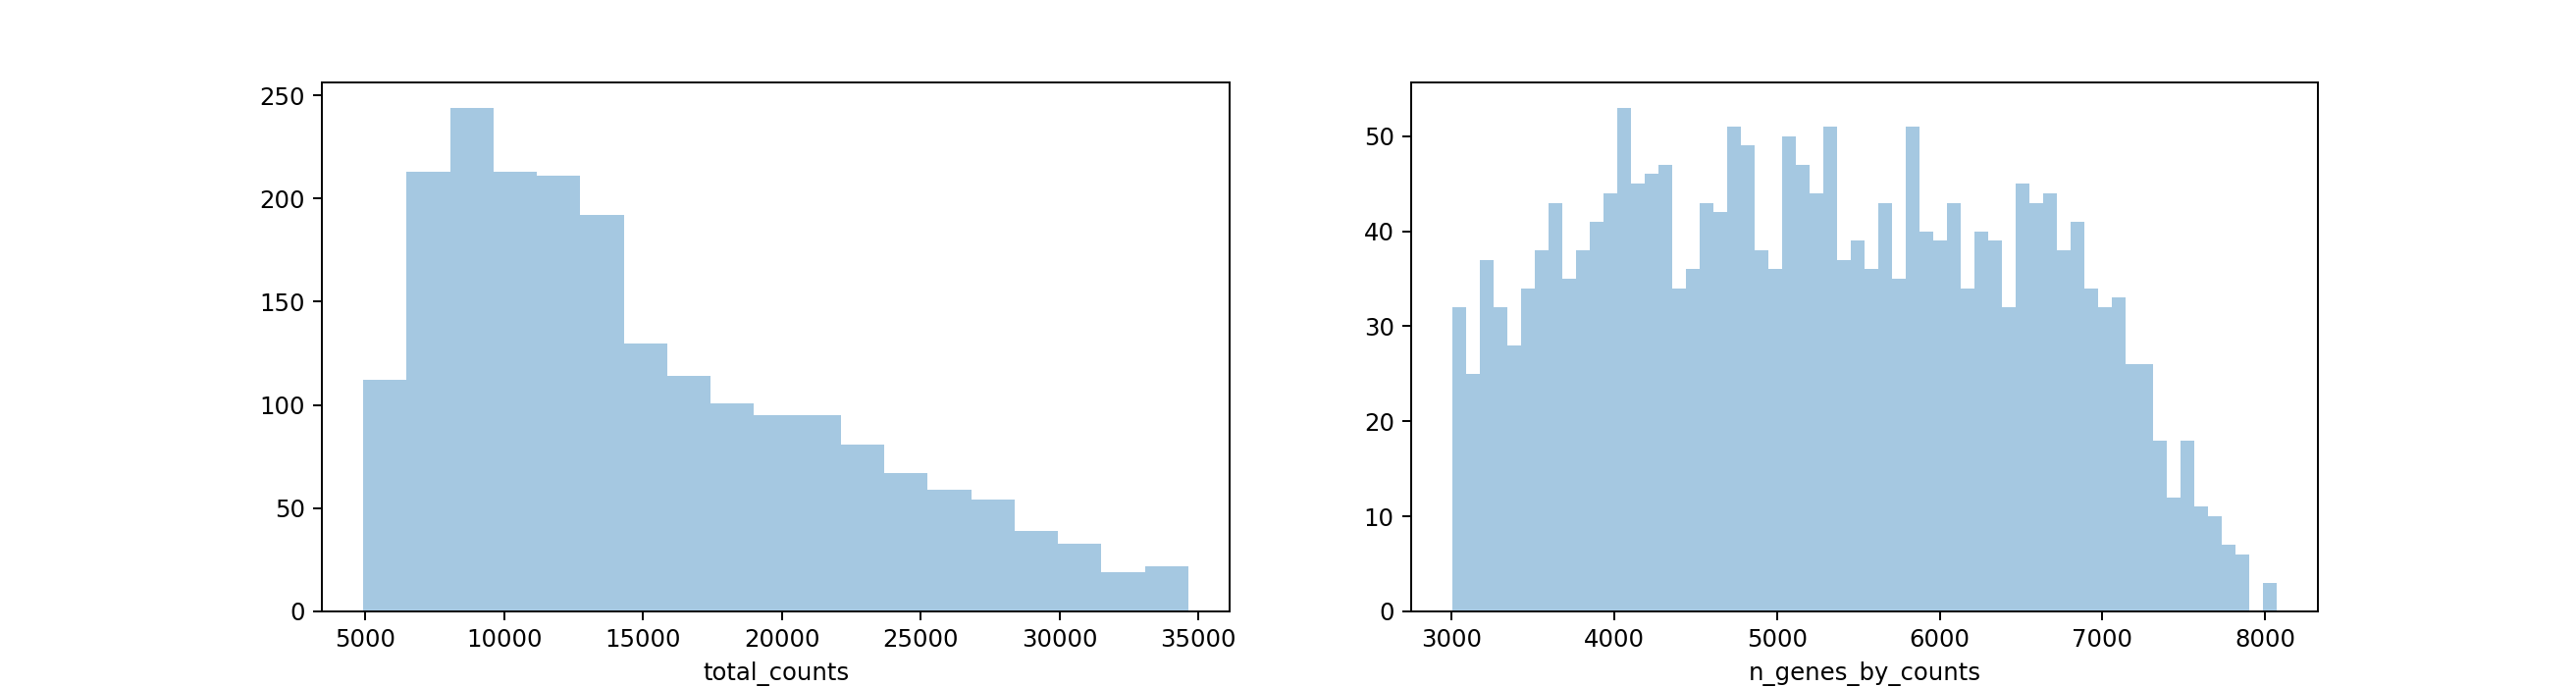

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

In [9]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ffpe_human_breast_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ffpe_human_breast_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [10]:
#Perform next steps in cluster identification
sc.pp.pca(ffpe_human_breast_cancer,n_comps=20)
sc.pp.neighbors(ffpe_human_breast_cancer)
sc.tl.umap(ffpe_human_breast_cancer)
sc.tl.leiden(ffpe_human_breast_cancer, key_added='clusters')

<IPython.core.display.Javascript object>


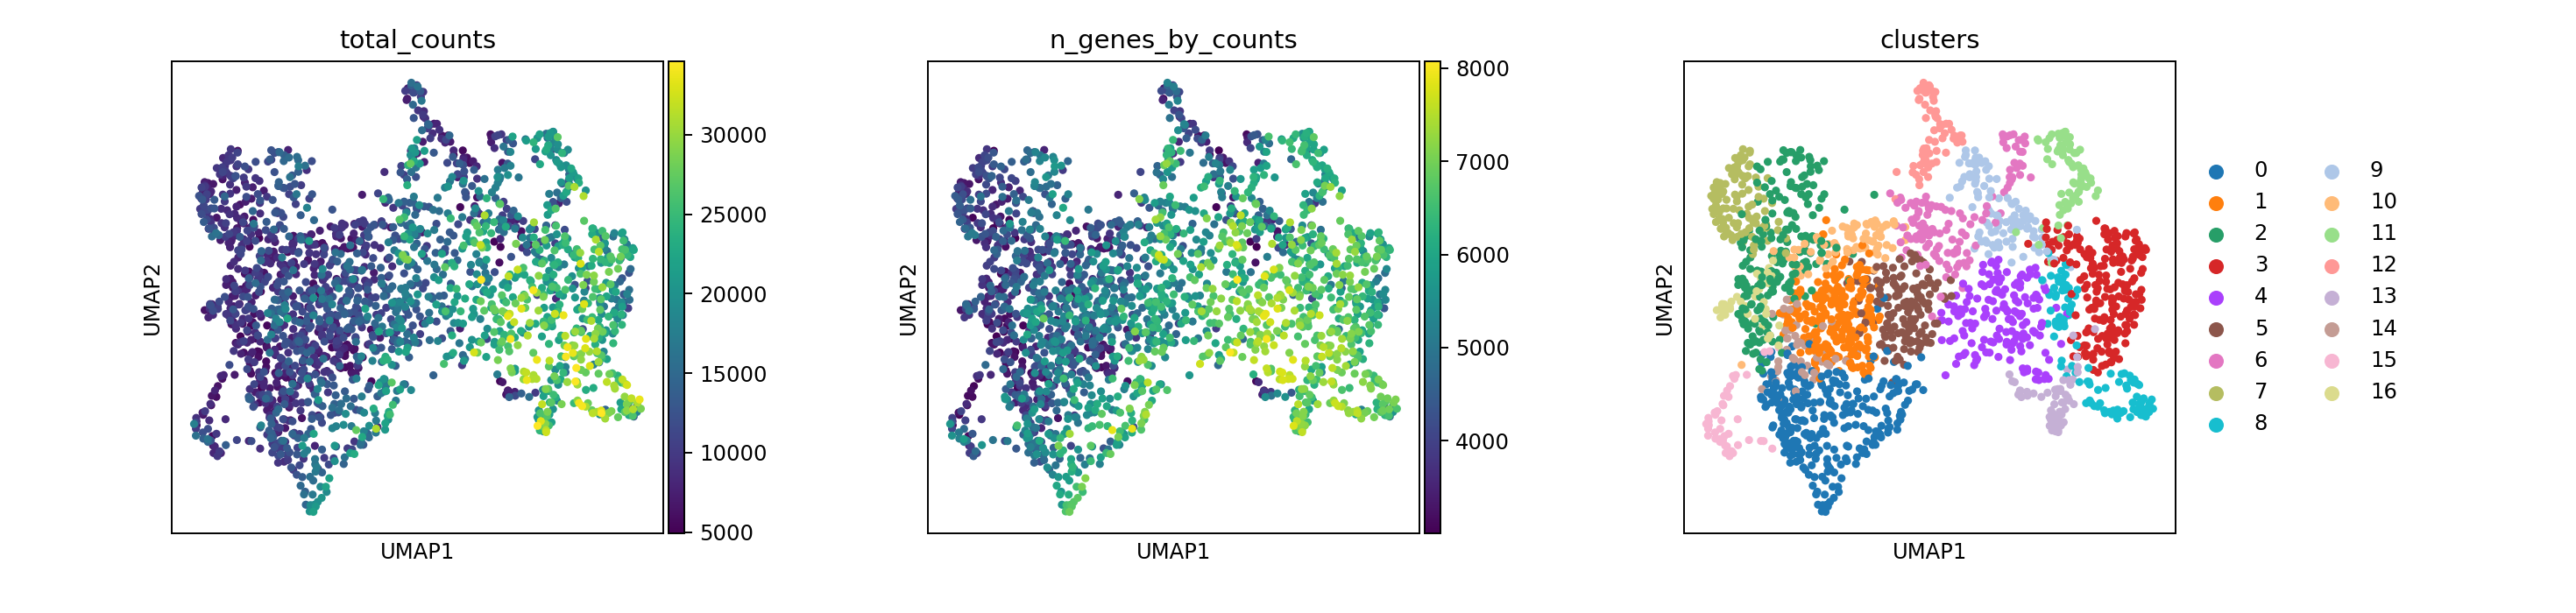

In [11]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ffpe_human_breast_cancer, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


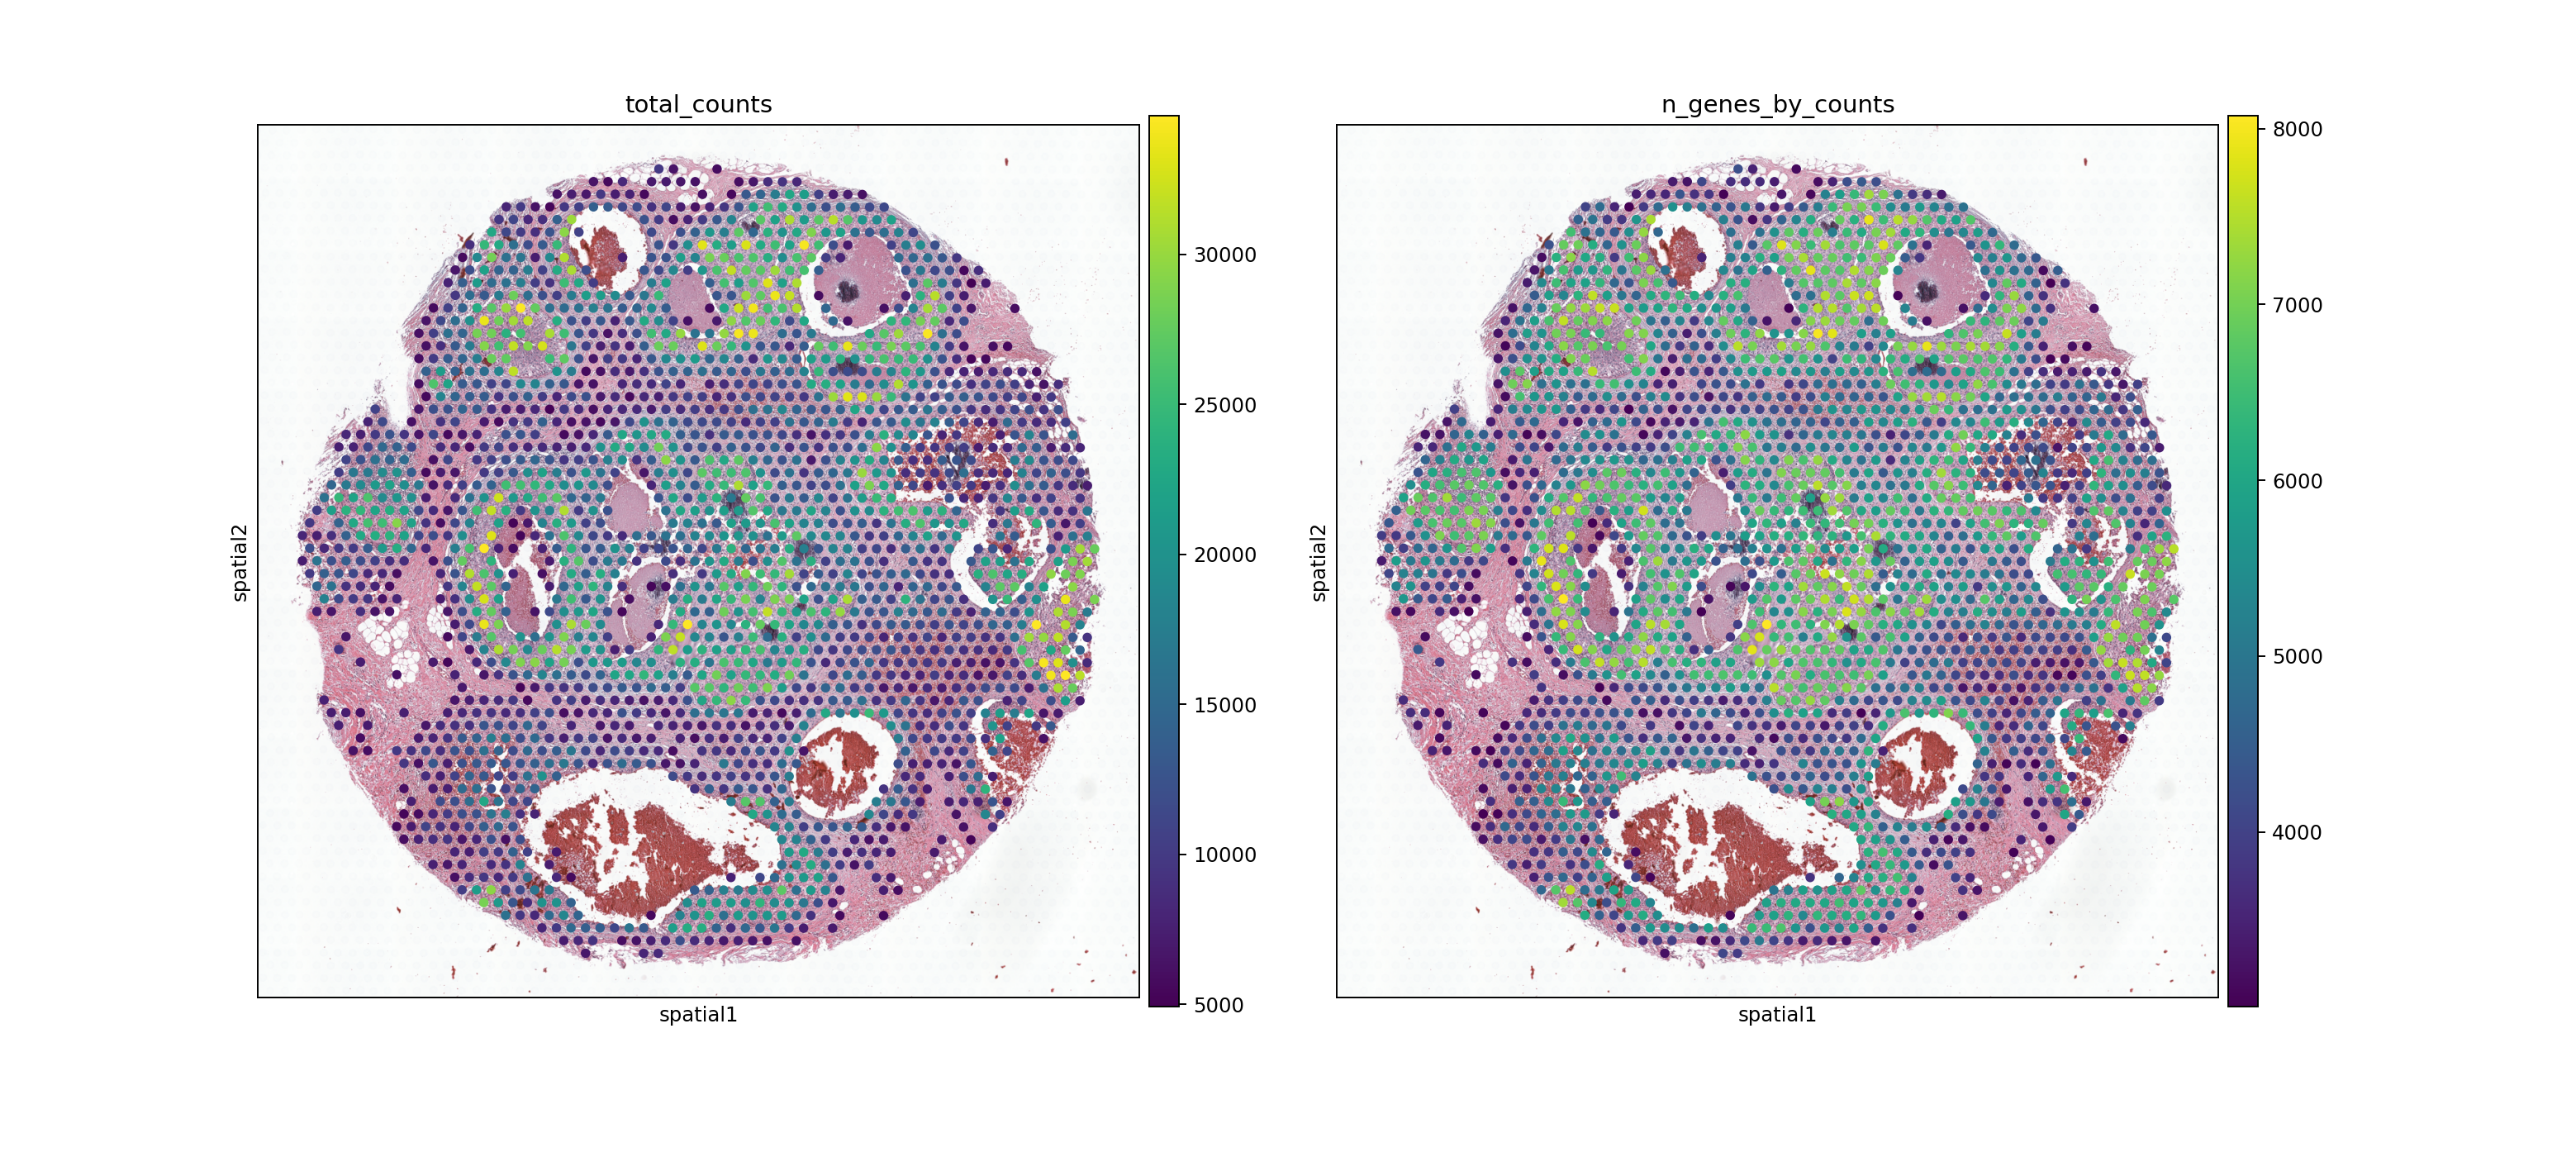

In [12]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ffpe_human_breast_cancer, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


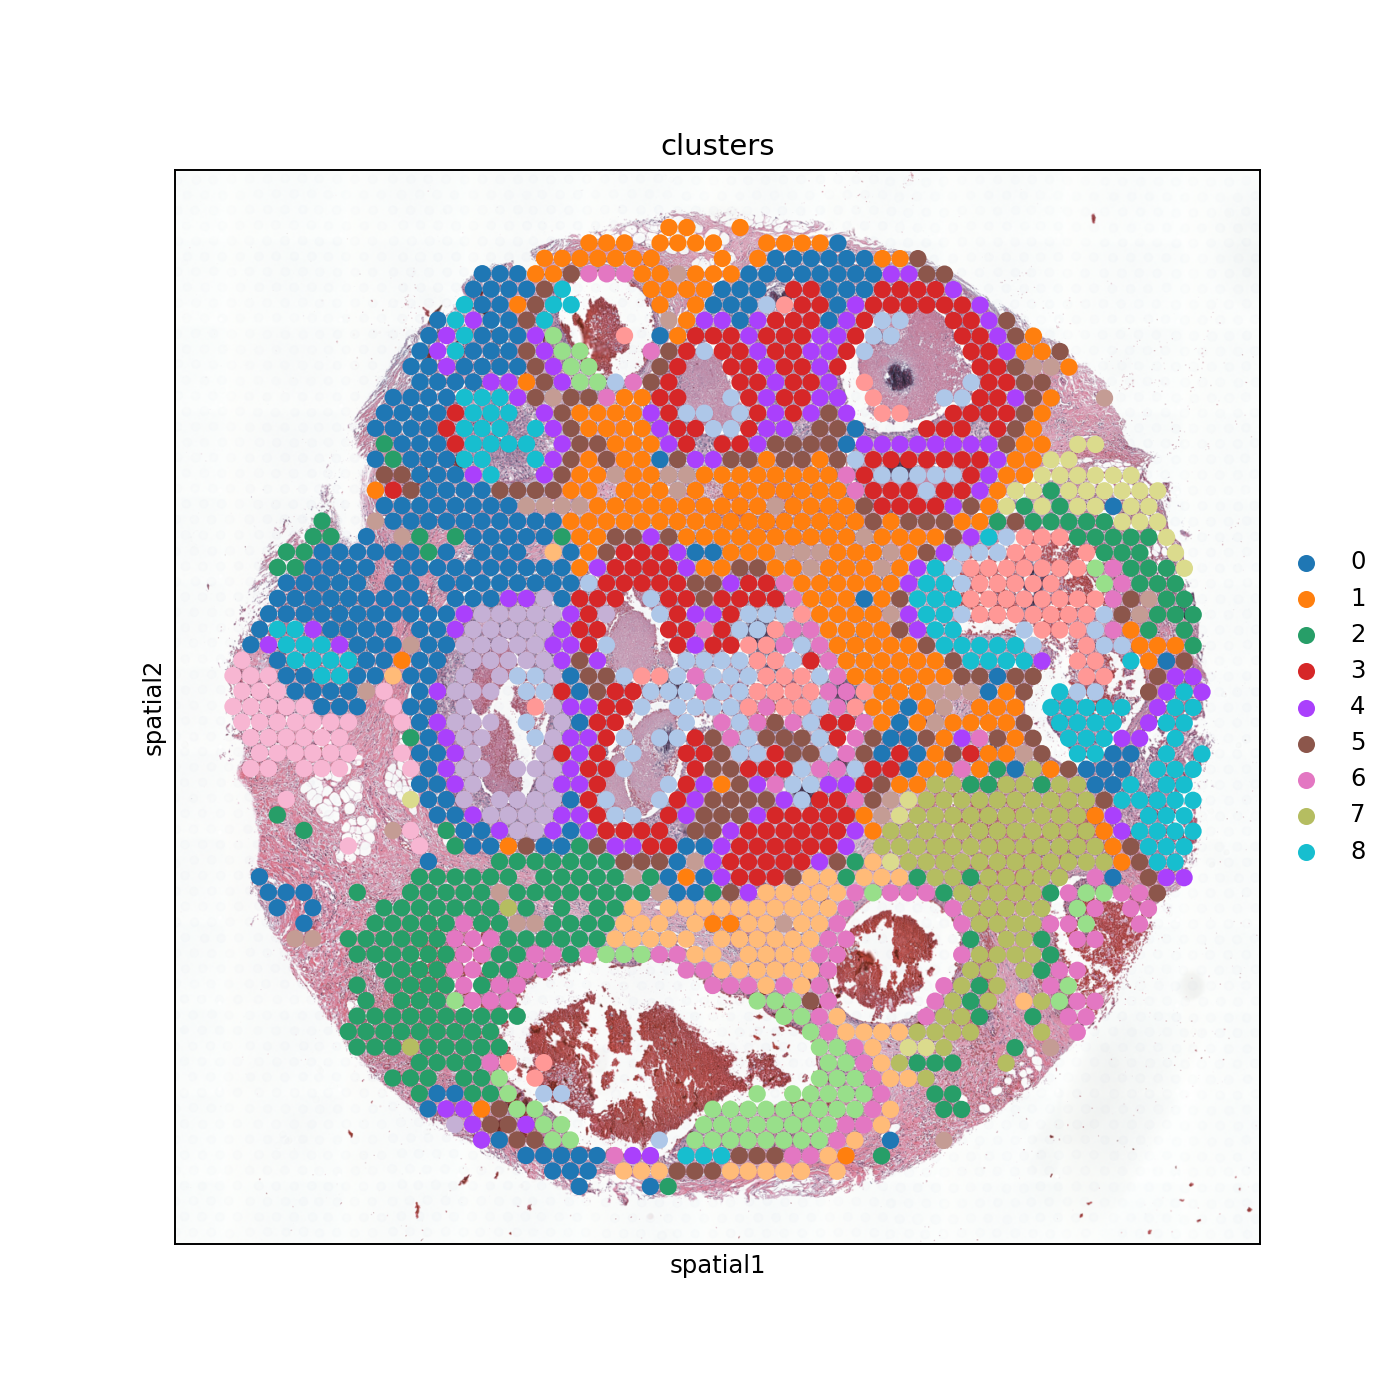

In [13]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(ffpe_human_breast_cancer, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


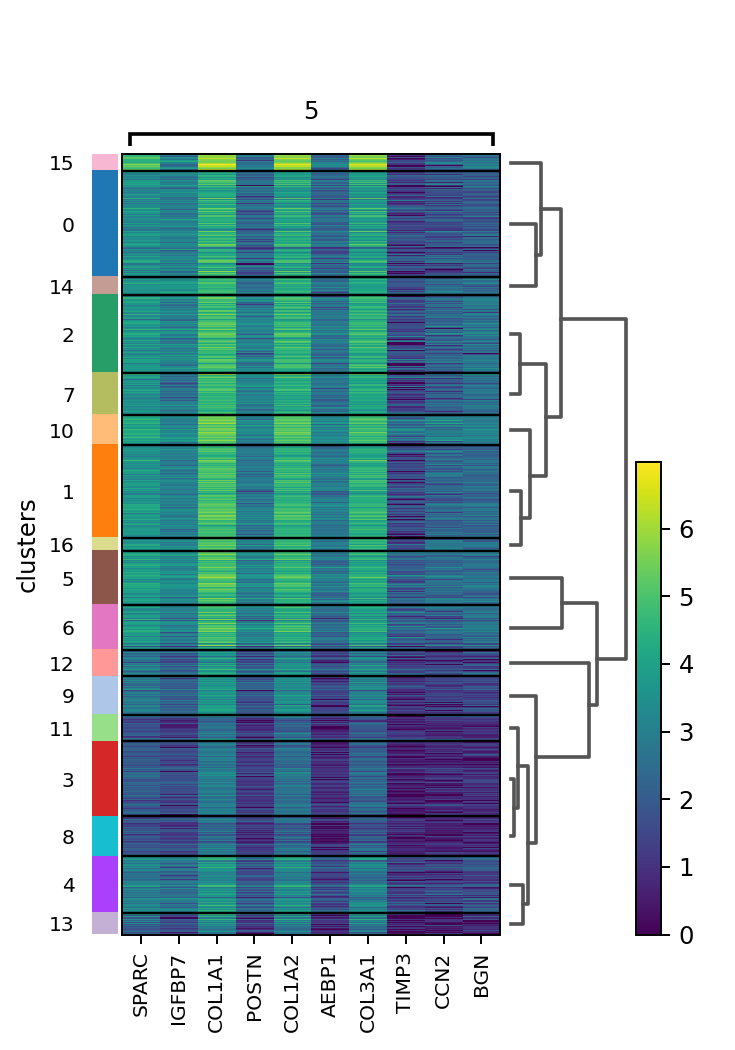

In [14]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(ffpe_human_breast_cancer, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(ffpe_human_breast_cancer, groups="5", n_genes=10, groupby="clusters")

### Write out processed files

In [15]:
##write this AnnData object to a didfferent file format
ffpe_human_breast_cancer.write_h5ad(filename='ffpe_breast_cancer.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

In [16]:
#Write out normalised dataframe with expression values to file so it can be read back in for this purpose
ffpe_human_breast_cancer.write_csvs('preprocessed_output/',skip_data=False)

### Find SVGs using SpatialDE

In [16]:
%%time
#Now try and find SVGs with SpatialDE
#We need to convert normalised counts into a DF for spatial DE

counts = pd.DataFrame(ffpe_human_breast_cancer.X.todense(), columns=ffpe_human_breast_cancer.var_names, index=ffpe_human_breast_cancer.obs_names)
coord = pd.DataFrame(ffpe_human_breast_cancer.obsm['spatial'], columns=['x_coord', 'y_coord'], index=ffpe_human_breast_cancer.obs_names)
results = SpatialDE.run(coord, counts)

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

  0%|          | 0/14931 [00:00<?, ?it/s]

CPU times: user 7min 36s, sys: 1.98 s, total: 7min 38s
Wall time: 7min 39s


In [16]:
#Look at top 10 values
results.sort_values("qval").head(10)

FSV  M         g           l  max_delta       max_ll  max_mu_hat  \
7465  0.198172  4      DSG2  482.077739   4.015902  -947.216135    0.264609   
8140  0.227763  4  HSP90AB1  879.005545   3.309223 -1083.109359    2.194471   
8138  0.202192  4     YIPF3  879.005545   3.851170 -1661.110897    1.358528   
8136  0.258995  4     FOXP4  879.005545   2.792468 -1702.849815    0.754934   
8135  0.225371  4      GLO1  879.005545   3.354707 -1738.729872    0.971263   
8134  0.185859  4      PIM1  879.005545   4.275381 -1376.181589    0.350788   
8133  0.229143  4      PI16  879.005545   3.283414   209.529887    0.075223   
8132  0.163376  4    MAPK13  879.005545   4.998046 -1616.279957    0.695079   
8130  0.209810  4      RGL2  879.005545   3.675890 -1761.971303    1.066866   
8129  0.146357  4   SLC39A7  879.005545   5.692709 -1711.826472    1.149591   

      max_s2_t_hat model     n    s2_FSV  s2_logdelta      time          BIC  \
7465      0.034715    SE  2094  0.000014     0.000564  0.001871  1925.019595   
8140      0.143586    SE  2094  0.000039     0.001290  0.001698  2196.806044   
8138      0.104765    SE  2094  0.000040     0.001554  0.001662  3352.809119   
8136      0.107064    SE  2094  0.000041     0.001172  0.001705  3436.286957   
8135      0.102170    SE  2094  0.000037     0.001236  0.001525  3508.047069   
8134      0.049031    SE  2094  0.000040     0.001700  0.001481  2782.950504   
8133      0.013269    SE  2094  0.000055     0.001826  0.001476  -388.472448   
8132      0.059951    SE  2094  0.000035     0.001771  0.001479  3263.147240   
8130      0.100784    SE  2094  0.000040     0.001455  0.001666  3554.529932   
8129      0.074287    SE  2094  0.000035     0.002117  0.001485  3454.240269   

      max_ll_null         LLR  pval  qval  
7465 -1034.129838   86.913703   0.0   0.0  
8140 -1214.506801  131.397442   0.0   0.0  
8138 -1781.018147  119.907250   0.0   0.0  
8136 -1859.573171  156.723355   0.0   0.0  
8135 -1867.852310  129.122439   0.0   0.0  
8134 -1479.124625  102.943036   0.0   0.0  
8133   120.084009   89.445878   0.0   0.0  
8132 -1695.656805   79.376847   0.0   0.0  
8130 -1891.306656  129.335353   0.0   0.0  
8129 -1787.351751   75.525279   0.0   0.0

In [17]:
#Sort results for all qvals >= 0.05 and add them to file
results_filtered = results[results["qval"] <= 0.05]
results_filtered = results_filtered.sort_values(by="qval")
results_filtered.to_csv('ffpe_breast_cancer_svgs_spatialde.csv')
results_filtered

FSV  M         g            l  max_delta       max_ll  max_mu_hat  \
7590   0.348343  4      ADA2   482.077739   1.856760 -1784.203992    0.697788   
7301   0.186391  4      INF2   482.077739   4.332439 -1725.816978    1.413455   
7302   0.264971  4     CRIP2   482.077739   2.753276 -1879.344901    1.236211   
7303   0.228557  4     CRIP1   482.077739   3.350057 -1870.586751    0.757893   
7304   0.706400  4     IGHG4   482.077739   0.412524 -2518.699575    1.595383   
...         ... ..       ...          ...        ...          ...         ...   
2006   0.320349  4  SLC22A23   145.000000   2.120861  -899.064114    0.254103   
13698  0.022824  4      THEG  2922.406933  34.026007  1473.340749    0.024561   
5135   0.323852  4    HOXB13   145.000000   2.087111   640.483039    0.053968   
14291  0.014043  4   GPRASP1  2922.406933  55.798733   131.699867    0.079558   
3133   0.323151  4     MASTL   145.000000   2.093811  -502.481139    0.158727   

       max_s2_t_hat model     n    s2_FSV  s2_logdelta      time          BIC  \
7590       0.165167    SE  2094  0.000010     0.000217  0.001466  3598.995310   
7301       0.160791    SE  2094  0.000018     0.000761  0.001851  3482.221281   
7302       0.189856    SE  2094  0.000014     0.000392  0.001658  3789.277127   
7303       0.118853    SE  2094  0.000017     0.000551  0.001680  3771.760827   
7304       1.113407    SE  2094  0.000003     0.000078  0.001293  5067.986475   
...             ...   ...   ...       ...          ...       ...          ...   
2006       0.061326    SE  2094  0.002103     0.049110  0.001488  1828.715555   
13698      0.000418    SE  2094  0.000111     0.169272  0.003573 -2916.094172   
5135       0.011103    SE  2094  0.002443     0.056529  0.001466 -1250.378753   
14291      0.000933    SE  2094  0.000096     0.373108  0.003046  -232.812409   
3133       0.037345    SE  2094  0.002770     0.064217  0.001359  1035.549604   

       max_ll_null         LLR      pval      qval  
7590  -2041.051036  256.847044  0.000000  0.000000  
7301  -1800.911149   75.094171  0.000000  0.000000  
7302  -2022.187352  142.842451  0.000000  0.000000  
7303  -1966.181408   95.594658  0.000000  0.000000  
7304  -3468.399031  949.699457  0.000000  0.000000  
...            ...         ...       ...       ...  
2006   -904.488538    5.424424  0.019857  0.049776  
13698  1467.917441    5.423308  0.019870  0.049786  
5135    635.061492    5.421548  0.019890  0.049828  
14291   126.280253    5.419614  0.019912  0.049871  
3133   -507.900584    5.419445  0.019914  0.049871  

[5962 rows x 18 columns]